In [16]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import cftime
import datetime
import xarray as xr
import wget
import os
import glob
import matplotlib.pyplot as plt
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pygrib
%matplotlib inline

In [17]:
os.chdir('/Users/caramelo/Documents/0000_Unu_Engineering/wasabi_cloud_storage/gem/TMP')
grib_list_total=sorted(glob.glob('*0312_*.grib2'))
grib_list=grib_list_total[0:7]
grib_list

['CMC_reg_TMP_TGL_2_ps10km_2021030312_P000.grib2',
 'CMC_reg_TMP_TGL_2_ps10km_2021030312_P001.grib2',
 'CMC_reg_TMP_TGL_2_ps10km_2021030312_P002.grib2',
 'CMC_reg_TMP_TGL_2_ps10km_2021030312_P003.grib2',
 'CMC_reg_TMP_TGL_2_ps10km_2021030312_P004.grib2',
 'CMC_reg_TMP_TGL_2_ps10km_2021030312_P005.grib2',
 'CMC_reg_TMP_TGL_2_ps10km_2021030312_P006.grib2']

# Test avec un seul fichier grib

In [23]:
ds_test=xr.open_dataset(grib_list[0],engine='cfgrib', decode_cf=True)
ds_test_rasterio=xr.open_rasterio(grib_list[0])


J'utilise rasterio pour aller chercher l'information du crs (coordinate reference system)


In [35]:
proj_stereo_polar=ds_test_rasterio.crs
ds_test_rasterio.crs

'+proj=stere +lat_0=90 +lat_ts=60 +lon_0=249 +x_0=0 +y_0=0 +R=6371229 +units=m +no_defs=True'

Maintenant analysons les latitudes et longitudes tel qu'explorées avec la librairie pygrib

In [26]:
grbs=pygrib.open(grib_list[0])
grb=grbs[1]
lats,lons=grb.latlons()

In [34]:
lats.shape

(824, 935)

In [32]:
lons.shape

(824, 935)

Le fait que les coordonnées ont deux dimensions, ça montre que c'est une grille irregulière

Il faut consulter les informations d'environnement canada pour le modèle régional. https://weather.gc.ca/grib/grib2_reg_10km_e.html

Dans ce site on trouve un lien vers les coordonnées du modèle stéréographique polaire.

In [42]:
from pyproj import CRS, Transformer

crs_out = CRS.from_proj4("+proj=latlon")
crs_in = CRS.from_proj4(proj_stereo_polar)

crs_in

<Projected CRS: +proj=stere +lat_0=90 +lat_ts=60 +lon_0=249 +x_0=0 ...>
Name: unknown
Axis Info [cartesian]:
- E[south]: Easting (metre)
- N[south]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Polar Stereographic (variant B)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

In [44]:
transformer = Transformer.from_crs(crs_in, crs_out)
transformer

<Concatenated Operation Transformer: pipeline>
Description: Inverse of unknown + Ballpark geographic offset from unknown to unknown
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)

Lecture du fichier d'environnement canada

In [62]:
coords_rdps=pd.read_csv('/Users/caramelo/Documents/0000_Unu_Engineering/wasabi_cloud_storage/gem/10km.csv')
lats_10km=coords_rdps.lat.to_numpy()
lon_10km=coords_rdps.lon.to_numpy()
type(lats_10km)

numpy.ndarray

In [57]:
transformer.transform(lats_10km, lon_10km)#top left corner selon Panoplyto_numpy

TypeError: input must be an array, list, tuple or scalar

In [63]:
x_coords = np.random.randint(80000, 120000)
type(x_coords)
x_coords

82253

In [19]:
ds_test.t2m.values#il y a des nan donc la valeur est déjà reprojetée

array([[294.4892 , 294.5392 , 294.5892 , ..., 299.26422, 299.2392 ,
        299.1892 ],
       [294.3392 , 294.2892 , 294.26422, ..., 299.2392 , 299.2142 ,
        299.13922],
       [294.1142 , 294.01422, 293.9392 , ..., 299.1892 , 299.13922,
        299.0892 ],
       ...,
       [262.7392 , 262.2392 , 262.01422, ...,       nan,       nan,
              nan],
       [263.3392 , 262.6892 , 262.3392 , ...,       nan,       nan,
              nan],
       [263.9642 , 263.2142 , 262.8392 , ...,       nan,       nan,
              nan]], dtype=float32)

In [22]:
ds_test.latitude.values

array([[18.14503   , 18.17840149, 18.21173404, ..., 17.4111873 ,
        17.3769743 , 17.34272612],
       [18.19869826, 18.23212537, 18.26551351, ..., 17.46364524,
        17.42937639, 17.39507236],
       [18.25238237, 18.28586518, 18.31930902, ..., 17.51611696,
        17.48179217, 17.4474322 ],
       ...,
       [47.37108253, 47.45317877, 47.53531405, ..., 45.5984489 ,
        45.51726527, 45.43612289],
       [47.35484472, 47.43689746, 47.51898908, ..., 45.58311487,
        45.50197108, 45.42086839],
       [47.33843536, 47.42044418, 47.5024917 , ..., 45.56761825,
        45.4865147 , 45.40545211]])

In [62]:
ds_test

<xarray.Dataset>
Dimensions:            (x: 935, y: 824)
Coordinates:
    time               datetime64[ns] 2021-03-03T12:00:00
    step               timedelta64[ns] 00:00:00
    heightAboveGround  int64 2
    latitude           (y, x) float64 18.15 18.18 18.21 ... 45.57 45.49 45.41
    longitude          (y, x) float64 217.1 217.2 217.2 ... 349.9 349.8 349.8
    valid_time         datetime64[ns] 2021-03-03T12:00:00
Dimensions without coordinates: x, y
Data variables:
    t2m                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal 
    history:                 2021-03-10T14:26:04 GRIB to CDM+CF via cfgrib-0....

In [7]:
ds_test.swap_dims({"x": "longitude"}) 

ValueError: replacement dimension 'longitude' is not a 1D variable along the old dimension 'x'

In [14]:
ds_test.longitude.values

array([[217.107456  , 217.16395904, 217.22053137, ..., 282.10228004,
        282.15721528, 282.21208178],
       [217.07228304, 217.12882027, 217.18542696, ..., 282.13815181,
        282.19311727, 282.24801383],
       [217.03704065, 217.09361204, 217.15025307, ..., 282.17409252,
        282.22908817, 282.28401475],
       ...,
       [147.8669735 , 147.84307356, 147.81907208, ..., 349.63796352,
        349.6162082 , 349.59454066],
       [147.74583254, 147.72168602, 147.697437  , ..., 349.75397787,
        349.73199644, 349.71010365],
       [147.62479343, 147.60040096, 147.57590506, ..., 349.86990305,
        349.84769606, 349.82557853]])

In [21]:
longitude=ds_test.longitude.values
long_test=longitude.reshape(1,770440)


In [11]:
ds_test.x.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

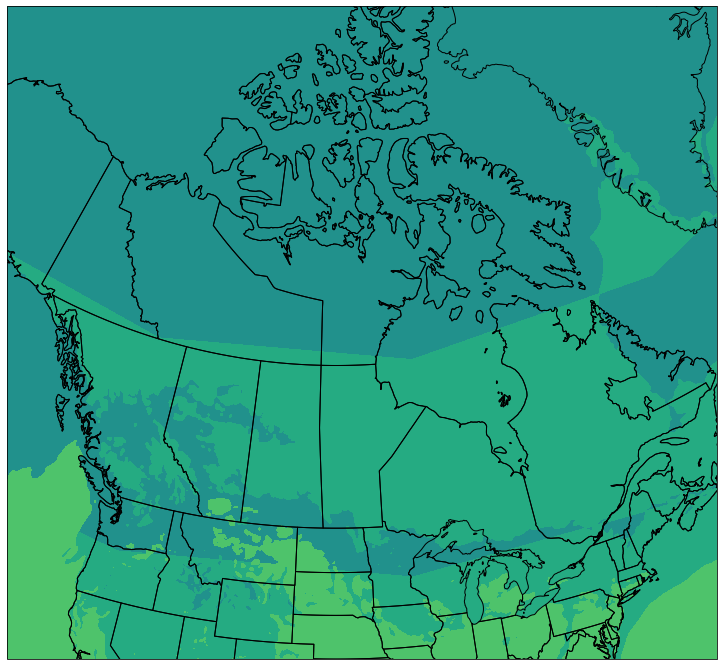

In [82]:
lats,lons=grb.latlons()
map_crs=ccrs.LambertConformal(central_longitude=-100,
                              central_latitude=53,
                             standard_parallels=(30,60))

data_crs=ccrs.PlateCarree()

fig=plt.figure(1,figsize=(14,12))
ax=plt.subplot(1,1,1,projection=map_crs)
ax.set_extent([-130,-65,40,80],data_crs)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

ax.contourf(lons,lats,grb.values,transform=data_crs)

# Test avec plusieurs fichiers grib

In [62]:
ds=xr.open_mfdataset(grib_list,concat_dim='valid_time',engine='cfgrib',parallel=True,combine='nested')


In [83]:
ds.latitude.values# x et y sont la longitude et latitude on dirait

array([[18.14503   , 18.17840149, 18.21173404, ..., 17.4111873 ,
        17.3769743 , 17.34272612],
       [18.19869826, 18.23212537, 18.26551351, ..., 17.46364524,
        17.42937639, 17.39507236],
       [18.25238237, 18.28586518, 18.31930902, ..., 17.51611696,
        17.48179217, 17.4474322 ],
       ...,
       [47.37108253, 47.45317877, 47.53531405, ..., 45.5984489 ,
        45.51726527, 45.43612289],
       [47.35484472, 47.43689746, 47.51898908, ..., 45.58311487,
        45.50197108, 45.42086839],
       [47.33843536, 47.42044418, 47.5024917 , ..., 45.56761825,
        45.4865147 , 45.40545211]])

In [84]:
lats

array([[18.14503   , 18.17840149, 18.21173404, ..., 17.4111873 ,
        17.3769743 , 17.34272612],
       [18.19869826, 18.23212537, 18.26551351, ..., 17.46364524,
        17.42937639, 17.39507236],
       [18.25238237, 18.28586518, 18.31930902, ..., 17.51611696,
        17.48179217, 17.4474322 ],
       ...,
       [47.37108253, 47.45317877, 47.53531405, ..., 45.5984489 ,
        45.51726527, 45.43612289],
       [47.35484472, 47.43689746, 47.51898908, ..., 45.58311487,
        45.50197108, 45.42086839],
       [47.33843536, 47.42044418, 47.5024917 , ..., 45.56761825,
        45.4865147 , 45.40545211]])

In [85]:
# Convert to celsius
ds=ds-273.15 #passage en celsius
t2m = ds.t2m 

# copy attributes to get nice figure labels and change Kelvin to Celsius
t2m.attrs = ds.t2m.attrs

t2m.attrs["units"] = "deg C"

In [22]:
ds

<xarray.Dataset>
Dimensions:            (valid_time: 7, x: 935, y: 824)
Coordinates:
    time               datetime64[ns] 2021-03-03T12:00:00
    step               (valid_time) timedelta64[ns] 00:00:00 ... 06:00:00
    heightAboveGround  int64 2
    latitude           (y, x) float64 dask.array<chunksize=(824, 935), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(824, 935), meta=np.ndarray>
  * valid_time         (valid_time) datetime64[ns] 2021-03-03T12:00:00 ... 20...
Dimensions without coordinates: x, y
Data variables:
    t2m                (valid_time, y, x) float32 dask.array<chunksize=(1, 824, 935), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal 
    history:                 2021-03-09T14:32:19 GRIB to CDM+CF via cfgrib-0....

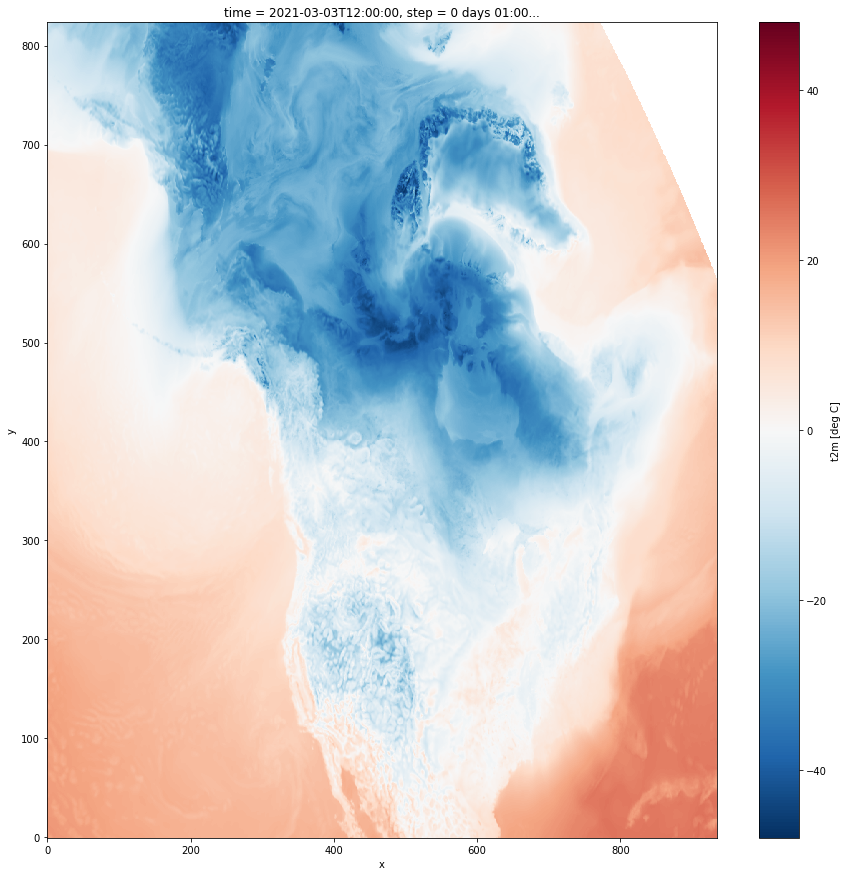

In [87]:
fig,ax=plt.subplots(figsize=(15,15))

#countries=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ds.t2m.isel(valid_time=1).plot(ax=ax)
#countries.plot(ax=ax,facecolor='none',edgecolor='red')

Deux alternatives pour le traitement des fichiers: Soit convertir les coordonnées des stations en stereographique polaire ou bien transformer les cartes en projection lat lon et garder les coordonnées telles quelles lors de la requête.


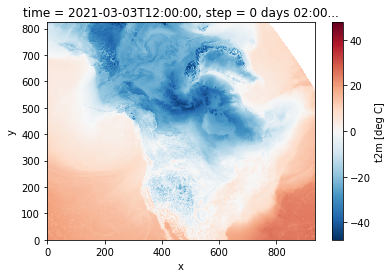

In [26]:
ds.t2m.isel(valid_time=[2]).plot()

# Première option: Changer les coordonnées des stations d'intérêt

Codes EPSG : https://spatialreference.org/ref/epsg/

Codes EPSG à prioriser pour le Québec: NAD83

In [27]:
coords_stations=pd.read_csv('/Users/caramelo/Documents/GitHub/cmc/Stations matrice scribe.csv')
coords_stations

,OACI,NOMSTN,LAT,LON
0,CYUL,MONTREAL (DORVAL),45.4667,-73.7500
1,CYOW,OTTAWA,45.3167,-75.6667
2,CYVO,VAL D'OR,48.0500,-77.7833
3,CYSC,SHERBROOKE,45.4333,-71.6833
4,CYQB,QUEBEC,46.8000,-71.4000
5,CYRJ,ROBERVAL,48.5167,-72.2667
6,CYGL,LA GRANDE RIVIERE,53.6333,-77.7000
7,CYBC,BAIE COMEAU,49.1333,-68.2000
8,CYZV,SEPT-ILES,50.2167,-66.2500
9,CYRQ,TROIS-RIVIÈRES (A),46.3539,-72.6792


In [28]:
xds_rasterio=xr.open_rasterio(grib_list[1])
outProj=xds_rasterio.crs



In [29]:
from pyproj import Proj, transform

inProj = Proj(init='epsg:4326')#lat lon
#outProj = Proj(init='epsg:3857')#faudrait avoir le epsg du rdps

#Roberval
latitude=coords_stations.iloc[5,2]
longitude=coords_stations.iloc[5,3]
#x1,y1 = -11705274.6374,4826473.6922
x2,y2 = transform(inProj,outProj,longitude,latitude)
print(x2,y2)

2817078.3652490648 -3512103.4612183035


/Users/caramelo/Documents/python-virtual-environments/rdpsgrib/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/caramelo/Documents/python-virtual-environments/rdpsgrib/lib/python3.9/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-29-60455755da6e>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/

In [31]:
t2m

<xarray.DataArray 't2m' (valid_time: 7, y: 824, x: 935)>
dask.array<sub, shape=(7, 824, 935), dtype=float32, chunksize=(1, 824, 935), chunktype=numpy.ndarray>
Coordinates:
    time               datetime64[ns] 2021-03-03T12:00:00
    step               (valid_time) timedelta64[ns] 00:00:00 ... 06:00:00
    heightAboveGround  int64 2
    latitude           (y, x) float64 dask.array<chunksize=(824, 935), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(824, 935), meta=np.ndarray>
  * valid_time         (valid_time) datetime64[ns] 2021-03-03T12:00:00 ... 20...
Dimensions without coordinates: y, x
Attributes:
    units:    deg C

In [42]:
#bon maintenant vu que la température ne change pas trop, allons voir une station bien au nord...Roberval
t2m1d = t2m.sel(y=y2, x=x2,method='nearest')
df = t2m1d.reset_coords(drop=True).to_dataframe()
df.plot()
plt.title(coords_stations.iloc[5,1])

ValueError: cannot supply ``method`` or ``tolerance`` when the indexed dimension does not have an associated coordinate.